# Test validity step 4 : $P(B_f | ...) \propto -(d - B_c s_c)^t N^{-1} B_f (B_f^t N^{-1} B_f)^{-1} B_f^t N^{-1} (d-B_c s_c) + \eta^t N_c^{1/2} (S_{approx} + E^t (B^T N^{-1} B)^{-1} E) N_c^{1/2} \eta$

In [1]:
import os, sys
import numpy as np
import matplotlib.pyplot as plt
import scipy
import healpy as hp
import astropy.io.fits as fits
import camb
import emcee
import jax
import jax.numpy as jnp
import jax.scipy as jsp
import micmac as micmac
# from mcmc_tools import *

from jax import config
config.update("jax_enable_x64", True)

In [2]:
sys.path.append(os.path.dirname(os.path.abspath('')))
sys.path.append(os.path.dirname(os.path.dirname(os.path.abspath('')))+'/tutorials/')
from func_tools_for_tests import *
from get_freq_maps_SO_64 import *
# freq_maps is defined there

OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


(6, 2, 49152)
(6, 2, 49152)


In [3]:
instrument

,frequency,depth_p,depth_i,fwhm,f_sky,status,reference,type,note,experiment
0,27.0,49.5,35.0,91.0,0.1,forecast,Journal of Cosmology and Astroparticle Physics...,ground,depth_p is simply depth_i * sqrt(2),SO_SAT
1,39.0,29.7,21.0,63.0,0.1,forecast,Journal of Cosmology and Astroparticle Physics...,ground,depth_p is simply depth_i * sqrt(2),SO_SAT
2,93.0,3.7,2.6,30.0,0.1,forecast,Journal of Cosmology and Astroparticle Physics...,ground,depth_p is simply depth_i * sqrt(2),SO_SAT
3,145.0,4.7,3.3,17.0,0.1,forecast,Journal of Cosmology and Astroparticle Physics...,ground,depth_p is simply depth_i * sqrt(2),SO_SAT
4,225.0,8.9,6.3,11.0,0.1,forecast,Journal of Cosmology and Astroparticle Physics...,ground,depth_p is simply depth_i * sqrt(2),SO_SAT
5,280.0,22.6,16.0,9.0,0.1,forecast,Journal of Cosmology and Astroparticle Physics...,ground,depth_p is simply depth_i * sqrt(2),SO_SAT


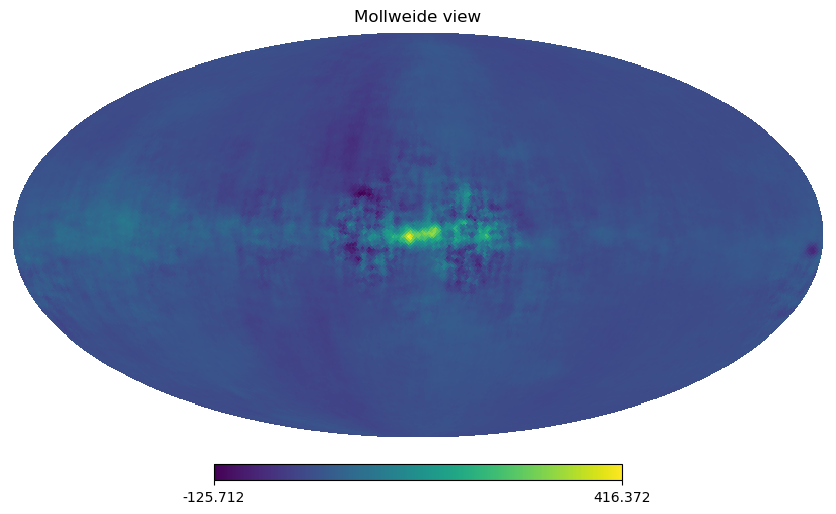

In [4]:
hp.mollview(freq_maps[0,0]) # Freq, nstokes, npix

In [5]:
nstokes = 2
nside = 64
lmax = nside*2
lmin = 2

number_frequencies = freq_maps.shape[0]
number_components = 3

limit_iter_cg=2000
tolerance_CG=10**(-12)

n_iter = 8

number_correlations = int(np.ceil(nstokes**2/2) + np.floor(nstokes/2))

param_dict = {'nside':nside, 'lmax':lmax, 'nstokes':nstokes, 'number_correlations':number_correlations,'number_frequencies':number_frequencies, 'number_components':number_components}
npix = 12*nside**2

In [6]:
all_spectra = generate_power_spectra_CAMB(nside*2, typeless_bool=True)
lensing_spectra = all_spectra['lensed_scalar'][:lmax+1,:]
camb_cls = all_spectra['total'][:lmax+1,:]

c_ells_input = np.zeros((6,lmax+1))
c_ells_input[:4,...] = camb_cls.T
c_ell_approx = np.zeros((6,lmax+1))
c_ell_approx[1] = camb_cls.T[1]
c_ell_approx[2] = lensing_spectra.T[2]


Calculating spectra from CAMB !


In [7]:
indices_polar = np.array([1,2,4])

if nstokes == 2:    
    c_ells_input = c_ells_input[indices_polar,:]
    c_ell_approx = c_ell_approx[indices_polar,:]
    # CMB_map_input = CMB_map_input[1:,:]
    # freq_maps = freq_maps[:,1:,:]

# CMB covariance preparation
red_cov_approx_matrix = micmac.get_reduced_matrix_from_c_ell(c_ell_approx)[lmin:,...]
red_cov_matrix = micmac.get_reduced_matrix_from_c_ell(c_ells_input)[lmin:,...]

# Mixing matrix initialization
init_mixing_matrix_obj = micmac.InitMixingMatrix(np.array(instrument['frequency']), number_components, pos_special_freqs=[-1,0])
init_params = init_mixing_matrix_obj.init_params()

mixing_matrix_obj = micmac.MixingMatrix(instrument['frequency'], number_components, init_params, pos_special_freqs=[-1,0])
# mixing_matrix_obj.update_params(mixing_matrix_obj.params/100)
mixing_matrix_sampled = mixing_matrix_obj.get_B()


# Noise initialization
depth_p = instrument['depth_p']
freq_inverse_noise = micmac.get_noise_covar(depth_p, nside)
cp_cp_noise = micmac.get_inv_BtinvNB(freq_inverse_noise, mixing_matrix_sampled)
cp_freq_inv_noise_sqrt = micmac.get_BtinvN(scipy.linalg.sqrtm(freq_inverse_noise), mixing_matrix_sampled)
cp_freq_inv_noise = micmac.get_BtinvN(freq_inverse_noise, mixing_matrix_sampled)

## Sampling $\eta$ : $P(\eta | ...) \propto \eta^t (S_{approx} + E^t (B^t N^{-1} B)^{-1} E) \eta$

In [8]:
%%time
eta_maps = np.zeros((nstokes, npix))
map_random_x = []
map_random_y = []
eta_maps = micmac.get_sampling_eta(param_dict, red_cov_approx_matrix, cp_cp_noise, cp_freq_inv_noise_sqrt, map_random_x=map_random_x, map_random_y=map_random_y, initial_guess=np.copy(eta_maps), lmin=lmin, n_iter=n_iter, limit_iter_cg=limit_iter_cg, tolerance=tolerance_CG)
eta_prime_maps = get_sampling_eta_prime(param_dict, red_cov_approx_matrix, cp_cp_noise, cp_freq_inv_noise_sqrt, map_random_x=map_random_x, map_random_y=map_random_y, initial_guess=np.copy(eta_maps), lmin=lmin, n_iter=n_iter, limit_iter_cg=limit_iter_cg, tolerance=tolerance_CG)


Recalculating x !
Recalculating y !
CG-Python eta sampling finished in  0 iterations !!
Recalculating x !
Recalculating y !
CPU times: user 455 ms, sys: 112 ms, total: 567 ms
Wall time: 105 ms


## Constrained map realization $s_c$ : $P(s_c | ...) \propto (s_c - s_{c,ML})^t (S_c + E^t (B^t N^{-1} B)^{-1} E)^{-1} (s_c - s_{c,ML})$

In [9]:
s_cML = np.einsum('kc,cf,fsp->ksp', cp_cp_noise, cp_freq_inv_noise, freq_maps)[0,...]

### Fluctuation part

In [10]:
%%time
initial_guess = np.zeros((nstokes,npix))
map_random_realization_xi = np.random.normal(loc=0, scale=1/hp.nside2resol(param_dict["nside"]), size=(param_dict["nstokes"],12*param_dict["nside"]**2))
map_random_realization_chi = np.random.normal(loc=0, scale=1/hp.nside2resol(param_dict["nside"]), size=(param_dict["number_frequencies"],param_dict["nstokes"],12*param_dict["nside"]**2))
fluctuation_maps = micmac.get_fluctuating_term_maps(param_dict, red_cov_matrix, cp_cp_noise, cp_freq_inv_noise_sqrt, map_random_realization_xi=map_random_realization_xi, map_random_realization_chi=map_random_realization_chi, initial_guess=initial_guess, lmin=lmin, n_iter=n_iter, limit_iter_cg=limit_iter_cg, tolerance=tolerance_CG)

CG-Python-0 Fluct finished in  265 iterations !!
CPU times: user 37.3 s, sys: 4.04 s, total: 41.3 s
Wall time: 6.1 s


### Wiener filter part

In [11]:
%%time
initial_guess = np.zeros((nstokes,npix))
wiener_filter_term = micmac.solve_generalized_wiener_filter_term(param_dict, s_cML, red_cov_matrix, cp_cp_noise, initial_guess=initial_guess, lmin=lmin, n_iter=n_iter, limit_iter_cg=limit_iter_cg, tolerance=tolerance_CG)

CG-Python-0 WF finished in  300 iterations !!
CPU times: user 42.3 s, sys: 4.77 s, total: 47 s
Wall time: 7.29 s


In [12]:
s_c_map = wiener_filter_term + fluctuation_maps

## Sampling $C$ through inverse Wishart sampling : $P(C | ...) \propto s_c^t C^{-1} s_c + ln|C|$

In [13]:
%%time
c_ells_Wishart = micmac.get_cell_from_map(s_c_map, lmax=lmax, n_iter=n_iter)


CPU times: user 118 ms, sys: 17.9 ms, total: 136 ms
Wall time: 28.7 ms


In [14]:
%%time
red_c_ells_inv_Wishart_sample = np.zeros((lmax+1, nstokes, nstokes))
c_ells_inv_Wishart_sample = np.zeros((number_correlations, lmax+1))

red_c_ells_inv_Wishart_sample = micmac.get_inverse_wishart_sampling_from_c_ells(np.copy(c_ells_Wishart), l_min=lmin)#[lmin:]
c_ells_inv_Wishart_sample = micmac.get_c_ells_from_red_covariance_matrix(red_c_ells_inv_Wishart_sample)

CPU times: user 47.3 ms, sys: 22.2 ms, total: 69.5 ms
Wall time: 13.5 ms


## Few statistics before sampling $\bold{B_f}$ 

## Sampling $\bold{B_f}$ : $P(B_f | ...) \propto -(d - B_c s_c)^t N^{-1} B_f (B_f^t N^{-1} B_f)^{-1} B_f^t N^{-1} (d-B_c s_c) + \eta^t N_c^{1/2} (S_{approx} + E^t (B^T N^{-1} B)^{-1} E) N_c^{1/2} \eta$

In [15]:
s_c_map_extended = np.zeros((number_components, nstokes, npix))
s_c_map_extended[0,...] = s_c_map

full_current_mixing_matrix = mixing_matrix_obj.get_B()

full_data_without_CMB = freq_maps - np.einsum('fc,csp->fsp',full_current_mixing_matrix, s_c_map_extended)

In [16]:
complete_mixing_matrix_fg = mixing_matrix_obj.get_B_fgs()
cp_freq_inv_noise_fg = micmac.get_BtinvN(freq_inverse_noise, complete_mixing_matrix_fg)
cp_cp_noise_fg = micmac.get_inv_BtinvNB(freq_inverse_noise, complete_mixing_matrix_fg)
print(cp_freq_inv_noise_fg, cp_freq_inv_noise_fg.shape, full_data_without_CMB.shape)

map_fgs = np.einsum('cf,fsp->csp', cp_freq_inv_noise_fg, full_data_without_CMB)
print('d-Bcsc -- mean', np.mean(full_data_without_CMB), 'max', np.max(full_data_without_CMB), 'min', np.min(full_data_without_CMB))
print('B_fN^{-1} (d-Bcsc) - mean', np.mean(map_fgs), 'max', np.max(map_fgs), 'min', np.min(map_fgs))
print('B_fN^{-1} - mean', np.mean(cp_freq_inv_noise_fg), 'max', np.max(cp_freq_inv_noise_fg), 'min', np.min(cp_freq_inv_noise_fg))
print('(B_f^t N^{-1} B_f)^{-1} - mean FG', np.mean(cp_cp_noise_fg), 'max', np.max(cp_cp_noise_fg), 'min', np.min(cp_cp_noise_fg))
print('(B_f^t N^{-1} B_f)^{-1} - mean', np.log(np.linalg.det(cp_cp_noise)))

first_residual = input_cmb_maps[0] - np.einsum('kc,cf,fsp->ksp', cp_cp_noise, cp_freq_inv_noise, freq_maps)[0]

[[0.00000000e+00 4.14656112e-02 1.14055148e+01 1.76728994e+01
  1.68138910e+01 5.91561031e+00]
 [1.23312198e+00 1.05351900e+01 1.10148903e+04 3.48472645e+04
  6.98035817e+04 0.00000000e+00]] (2, 6) (6, 2, 49152)
d-Bcsc -- mean 4.067818831676035 max 556.2172136505739 min -316.186186524365
B_fN^{-1} (d-Bcsc) - mean 211286.9477792749 max 20096731.44448354 min -11328201.08170408
B_fN^{-1} - mean 9644.112851111144 max 69803.58171339866 min 0.0
(B_f^t N^{-1} B_f)^{-1} - mean FG 0.036555033950238826 max 0.14629657153561887 min -3.82265067544959e-05
(B_f^t N^{-1} B_f)^{-1} - mean -26.14047069478387


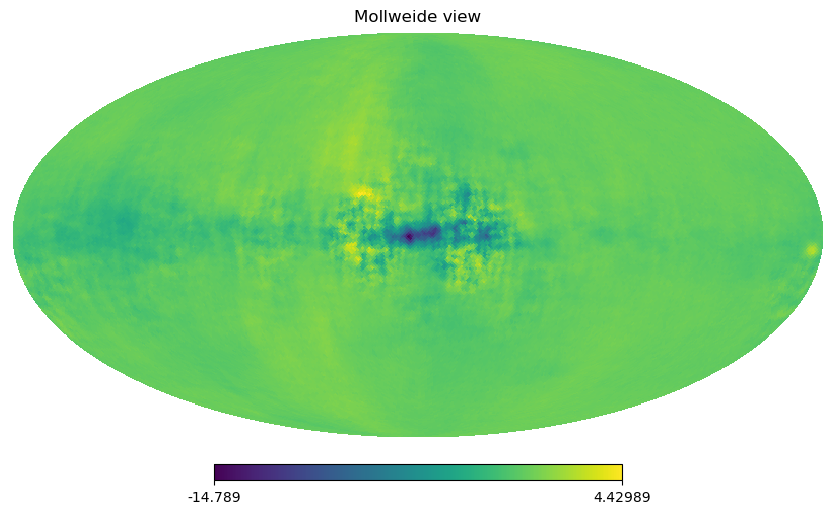

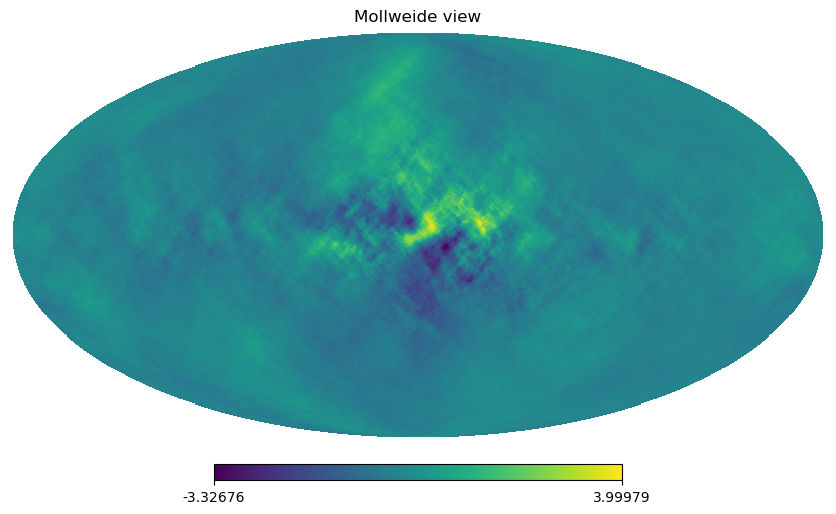

In [17]:
hp.mollview(first_residual[0])
hp.mollview(first_residual[1])

In [18]:
regularization_constant = -1
regularization_factor = 10**10

In [19]:
from functools import partial


In [20]:
# jitted_get_conditional_proba_mixing_matrix_foregrounds_alternative_JAX = jax.jit(get_conditional_proba_mixing_matrix_foregrounds_alternative_JAX, static_argnames=['number_components', 'nstokes', 'nside', 'lmin', 'n_iter', 'limit_iter_cg', 'tolerance', 'with_prints', 'regularization_constant', 'regularization_factor'])

def new_get_conditional_proba_mixing_matrix_foregrounds_alternative_JAX(params_mixing_matrix, pos_special_freqs=[-1,0], **model_kwargs):
    new_mixing_matrix = jnp.ones((param_dict['number_frequencies'],param_dict['number_components']))
    # new_mixing_matrix[0,1] = 0
    # new_mixing_matrix[-1,-1] = 0
    # new_mixing_matrix[1:,1:-1] = jnp.array(params_mixing_matrix.reshape((param_dict['number_frequencies']-2,param_dict['number_components']-1)))
    for c in range(param_dict['number_components']-1):
        new_mixing_matrix = new_mixing_matrix.at[pos_special_freqs[c],c].set(1)
    # new_mixing_matrix = new_mixing_matrix.at[0,1].set(0)
    # new_mixing_matrix = new_mixing_matrix.at[-1,-1].set(0)
    new_mixing_matrix = new_mixing_matrix.at[1:-1,1:].set(jnp.array(params_mixing_matrix.reshape((param_dict['number_frequencies']-2,param_dict['number_components']-1))))
    # print("Test ", model_kwargs['with_prints'], flush=True)
    return micmac.get_conditional_proba_mixing_matrix_foregrounds_alternative_JAX(jnp.copy(new_mixing_matrix), jnp.array(full_data_without_CMB), jnp.array(model_kwargs['eta_prime_maps']), freq_inverse_noise, red_cov_approx_matrix, param_dict['number_components'], param_dict['nstokes'], param_dict['nside'], lmin=lmin, n_iter=n_iter, limit_iter_cg=limit_iter_cg, tolerance=tolerance_CG, with_prints=model_kwargs['with_prints'], regularization_constant=regularization_constant, regularization_factor=regularization_factor)

    

In [21]:
%%time

# Calculation value log_proba with current value of B_f

# log_proba = micmac.get_conditional_proba_mixing_matrix_foregrounds(mixing_matrix_obj.params, mixing_matrix_obj, full_data_without_CMB, eta_maps, freq_inverse_noise, red_cov_approx_matrix, param_dict, lmin=lmin, n_iter=n_iter, limit_iter_cg=limit_iter_cg, tolerance=tolerance_CG, with_prints=True)
log_proba = new_get_conditional_proba_mixing_matrix_foregrounds_alternative_JAX(mixing_matrix_obj.params, pos_special_freqs=mixing_matrix_obj.pos_special_freqs, full_data_without_CMB=full_data_without_CMB, eta_prime_maps=eta_prime_maps, freq_inverse_noise=freq_inverse_noise, red_cov_approx_matrix=red_cov_approx_matrix, param_dict=param_dict, lmin=lmin, n_iter=n_iter, limit_iter_cg=limit_iter_cg, tolerance=tolerance_CG, with_prints=True, regularization_constant=regularization_constant, regularization_factor=regularization_factor)
print("Log_proba :", log_proba)
print("<-> Proba :", jnp.exp(log_proba))

CG-Python-0 WF finished in  None iterations !!
Log_proba : -0.7843595045092931
<-> Proba : 0.45641193797584606
CPU times: user 3.87 s, sys: 366 ms, total: 4.24 s
Wall time: 1.3 s


In [22]:
jitted_new_get_conditional_proba_mixing_matrix_foregrounds_alternative_JAX = jax.jit(new_get_conditional_proba_mixing_matrix_foregrounds_alternative_JAX, static_argnames=['with_prints'])

In [23]:
%%time

# Calculation value log_proba with current value of B_f
log_proba = jitted_new_get_conditional_proba_mixing_matrix_foregrounds_alternative_JAX(mixing_matrix_obj.params, pos_special_freqs=mixing_matrix_obj.pos_special_freqs, full_data_without_CMB=full_data_without_CMB, eta_prime_maps=eta_prime_maps, freq_inverse_noise=freq_inverse_noise, red_cov_approx_matrix=red_cov_approx_matrix, param_dict=param_dict, lmin=lmin, n_iter=n_iter, limit_iter_cg=limit_iter_cg, tolerance=tolerance_CG, with_prints=True, regularization_constant=regularization_constant, regularization_factor=regularization_factor)
print("Log_proba :", log_proba)
print("<-> Proba :", jnp.exp(log_proba))

Log_proba : -0.7843595045092931
<-> Proba : 0.45641193797584606
CPU times: user 3.91 s, sys: 601 ms, total: 4.51 s
Wall time: 925 ms


In [24]:
initial_guess_fg_mixing_matrix = mixing_matrix_obj.params.ravel()
dimensions_mixing_matrix = len(initial_guess_fg_mixing_matrix)
full_initial_guess = np.random.uniform(low=initial_guess_fg_mixing_matrix*.95,high=initial_guess_fg_mixing_matrix*1.05, size=(dimensions_mixing_matrix))

In [25]:
with_prints = False

number_steps_sampler = 1000
n_walkers = 4

kernel = MetropolisHastings(new_get_conditional_proba_mixing_matrix_foregrounds_alternative_JAX, step_size=0.5)
mcmc = MCMC(kernel, num_chains=n_walkers, num_warmup=0, num_samples=number_steps_sampler)


/var/folders/f8/p6tqlgxj2qn5x_tyjrvc1vnh0000gn/T/ipykernel_36995/2706662101.py:7: UserWarning: There are not enough devices to run parallel chains: expected 4 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(4)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  mcmc = MCMC(kernel, num_chains=n_walkers, num_warmup=0, num_samples=number_steps_sampler)


In [26]:
initial_guess_fg_mixing_matrix = mixing_matrix_obj.params.ravel()
dimensions_mixing_matrix = len(initial_guess_fg_mixing_matrix)
full_initial_guess = np.random.uniform(low=initial_guess_fg_mixing_matrix*.95,high=initial_guess_fg_mixing_matrix*1.05, size=(n_walkers,dimensions_mixing_matrix))
# full_initial_guess[0] = np.copy(initial_guess_fg_mixing_matrix)
print(mixing_matrix_obj.params, full_initial_guess)

[[1.21055502e-02 3.07566363e+00]
 [5.16775485e-02 4.99076579e+01]
 [1.29207310e-01 2.54769815e+02]
 [4.40790072e-01 1.82995869e+03]] [[1.24770757e-02 3.17900755e+00 4.97951187e-02 4.92253213e+01
  1.30738764e-01 2.54758980e+02 4.40752040e-01 1.82971711e+03]
 [1.22849438e-02 2.95615635e+00 4.98032395e-02 4.97279154e+01
  1.22905360e-01 2.63153982e+02 4.49005408e-01 1.85497189e+03]
 [1.17142790e-02 2.97612274e+00 5.37174118e-02 4.76674477e+01
  1.32491888e-01 2.45118617e+02 4.32939103e-01 1.75186088e+03]
 [1.20826957e-02 3.14714989e+00 5.35558662e-02 5.01879476e+01
  1.23481065e-01 2.53993356e+02 4.34722901e-01 1.79633672e+03]]


In [27]:
%%time 
mcmc.run(random.PRNGKey(0), init_params=full_initial_guess, full_data_without_CMB=jnp.array(full_data_without_CMB), eta_prime_maps=jnp.array(eta_prime_maps), freq_inverse_noise=jnp.array(freq_inverse_noise), red_cov_approx_matrix=jnp.array(red_cov_approx_matrix), param_dict=param_dict, lmin=lmin, n_iter=n_iter, limit_iter_cg=limit_iter_cg, tolerance=tolerance_CG, with_prints=with_prints)
samples = mcmc.get_samples(group_by_chain=True)
mcmc.print_summary()


sample: 100%|██████████| 1000/1000 [10:22<00:00,  1.61it/s]


                mean       std    median      5.0%     95.0%     n_eff     r_hat
Param:0[0]     -4.86     10.14     -2.16    -23.65      8.89      3.41      2.49
Param:0[1]      3.40     10.04      2.65     -9.71     24.42      3.42      2.26
Param:0[2]      2.07     17.97      2.90    -27.57     32.83      2.61      3.52
Param:0[3]     44.73      9.19     47.35     25.46     55.29      3.42      2.21
Param:0[4]      5.35     11.13      4.49    -11.21     22.21      3.07      2.99
Param:0[5]    247.91     15.28    251.25    223.73    266.94      2.65      3.45
Param:0[6]     -8.16     12.29     -3.71    -28.08      7.02      2.83      2.80
Param:0[7]   1814.53     40.87   1821.63   1750.45   1865.15      2.05      8.22

CPU times: user 4h 45min 25s, sys: 32min 18s, total: 5h 17min 44s
Wall time: 47min 6s


In [28]:
samples_chain = mcmc.get_samples(group_by_chain=True)

samples_chain.shape

(4, 1000, 8)

In [29]:
ver = 'J1a'
filename_backend_mcmc = "validation_numpyro_step_4_SO_{}ver{}".format(nside,ver)
np.save(filename_backend_mcmc, samples_chain)

In [30]:
chain_samples = mcmc.get_samples(group_by_chain=True)

In [31]:
gelman_rubin_statistic = numpyro.diagnostics.gelman_rubin(chain_samples)
print(gelman_rubin_statistic.shape)
gelman_rubin_statistic

(8,)


array([1.83342355, 1.79136402, 2.47767061, 1.79114742, 1.97505711,
       2.39102645, 2.13718369, 7.71824923])

In [32]:
gelman_rubin_statistic_0 = numpyro.diagnostics.gelman_rubin(np.mean(chain_samples,axis=2))
print(gelman_rubin_statistic_0.shape)
gelman_rubin_statistic_0

()


4.173108189485061

In [33]:
gelman_rubin_statistic_2 = numpyro.diagnostics.gelman_rubin(chain_samples[:2])
print(gelman_rubin_statistic_2.shape)
gelman_rubin_statistic_2

(8,)


array([1.28471094, 2.42021836, 2.58464444, 2.02191194, 1.07191771,
       3.42065517, 2.39569205, 2.58386433])

In [34]:
# old_sample = kernel.init(random.PRNGKey(0), init_params=full_initial_guess, full_data_without_CMB=jnp.array(full_data_without_CMB), eta_prime_maps=jnp.array(eta_prime_maps), freq_inverse_noise=jnp.array(freq_inverse_noise), red_cov_approx_matrix=jnp.array(red_cov_approx_matrix), param_dict=param_dict, lmin=lmin, n_iter=n_iter, limit_iter_cg=limit_iter_cg, tolerance=tolerance_CG, with_prints=with_prints)


# all_samples = np.zeros((number_steps_sampler, n_walkers, dimensions_mixing_matrix))

# for iteration in range(number_steps_sampler):
#     new_sample = kernel.sample(old_sample, full_data_without_CMB=jnp.array(full_data_without_CMB), eta_prime_maps=jnp.array(eta_prime_maps), freq_inverse_noise=jnp.array(freq_inverse_noise), red_cov_approx_matrix=jnp.array(red_cov_approx_matrix), param_dict=param_dict, lmin=lmin, n_iter=n_iter, limit_iter_cg=limit_iter_cg, tolerance=tolerance_CG, with_prints=with_prints)

#     old_sample = new_sample


#     # Only check convergence every 100 steps
#     if iteration % 100:
#         continue

#     # Compute the autocorrelation time so far
#     # Using tol=0 means that we'll always get an estimate even
#     # if it isn't trustworthy
#     tau = sample_params_mixing_matrix_FG.get_autocorr_time(tol=0)
#     autocorr[index] = np.mean(tau)
#     index += 1


In [35]:
samples.shape

(4, 1000, 8)

ValueError: x and y must have same first dimension, but have shapes (1000,) and (4, 1000)

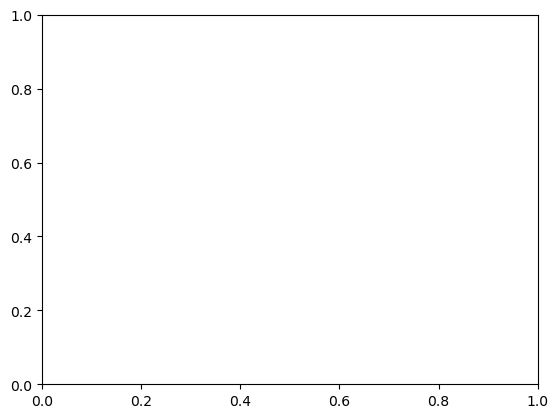

In [36]:
plt.plot(np.arange(number_steps_sampler), np.abs(samples.mean(axis=(2))))
# plt.plot(np.arange(number_steps_sampler), np.abs(samples.mean(axis=(1,2))))
plt.yscale('log')
plt.title(f"SO-{nside}")
plt.xlabel('Number iterations')
plt.ylabel('Mean value of abs(B_f)')
plt.show()

In [ ]:
autocorrelation = numpyro.diagnostics.autocorrelation(samples)
autocovariance = numpyro.diagnostics.autocovariance(samples)



In [ ]:
autocorrelation.shape

(700, 1, 8)

In [ ]:
autocovariance.shape

(700, 1, 8)

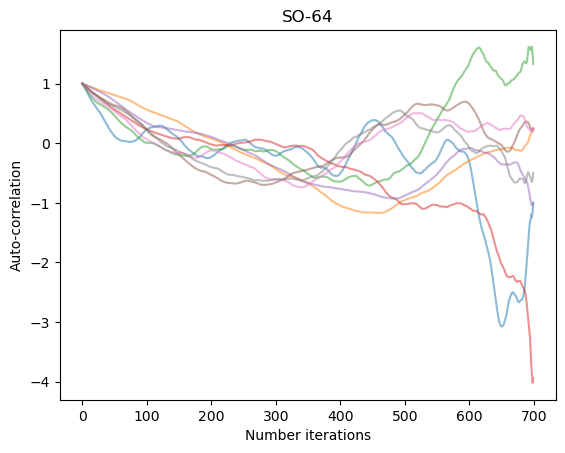

In [ ]:

plt.plot(np.arange(number_steps_sampler), autocorrelation[:,0,:], alpha=.5)
# plt.plot(np.arange(number_steps_sampler), np.mean(autocorrelation[:,0,:],axis=1), 'k')
# plt.loglog()
plt.title(f"SO-{nside}")
plt.xlabel('Number iterations')
plt.ylabel('Auto-correlation')
plt.show()

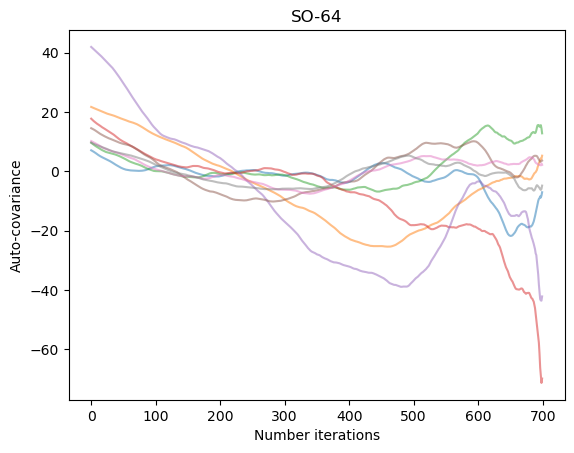

In [ ]:

plt.plot(np.arange(number_steps_sampler), autocovariance[:,0,:], alpha=.5)
# plt.plot(np.arange(number_steps_sampler), np.mean(autocorrelation[:,0,:],axis=1), 'k')
# plt.loglog()
plt.title(f"SO-{nside}")
plt.xlabel('Number iterations')
plt.ylabel('Auto-covariance')
plt.show()

In [ ]:
autocorrelation_times = np.array([1 + 2*(autocorrelation[i*100:(i+1)*100]/autocorrelation[i*100]).sum(axis=0) for i in range(7)])

In [ ]:
autocorrelation_times

array([[[   63.79095859,   161.09999382,    92.57021867,   118.28840687,
           140.00609   ,   127.25284414,   106.32375782,   124.70962088]],

       [[   36.13165418,   117.98385449, -3269.36898061,    88.14224889,
           128.78817579,  -166.22666612,  -386.79518031,  -109.06069047]],

       [[   57.40231003,  -417.4126455 ,   200.64159748,   -49.771898  ,
          -237.7484772 ,   245.3334249 ,   576.9414696 ,   277.548081  ]],

       [[  252.02666278,   327.10426618,   687.17852401,  2473.33222267,
           311.9451764 ,   135.31273953,   197.66334663,   169.83234917]],

       [[  -22.84121669,   213.27659937,   183.99638445,   331.68981548,
           224.29592965,  -114.16293229,   -55.83473957,  -462.63759895]],

       [[  192.70499288,   140.01772333,  -195.44609265,   204.70822879,
           111.9853972 ,   258.79124916,   194.04872554,    98.90293358]],

       [[ 1272.21949916,    78.94380689,   192.86804936,   358.05416182,
           835.13471414,    55.03

In [ ]:
import emcee.autocorr

In [ ]:
# https://github.com/dfm/emcee/blob/59b6a34323022bc547c3a9fb2173cbffe806af9b/src/emcee/backends/backend.py#L130
emcee.autocorr.integrated_time(samples, tol=0)

array([59.53177363, 85.31270358, 57.24913837, 91.02485449, 81.28128676,
       48.91212108, 53.95907357, 52.25562043])

In [ ]:
# %%time


# # And now sampling B_f using emcee

# n_walkers = 20
# # We have 6*3 parameters to sample, trying to go with 100 steps first
# # number_steps_sampler = 1000
# number_steps_sampler = 700
# with_prints = False

# # whole_chain_samples = micmac.sample_mixing_matrix_term(param_dict, mixing_matrix_obj, full_data_without_CMB, eta_prime_maps, red_cov_approx_matrix, freq_inverse_noise, lmin=lmin, n_iter=n_iter, limit_iter_cg=limit_iter_cg, tolerance=10**(-12), n_walkers=n_walkers, number_steps_sampler=number_steps_sampler, with_prints=with_prints)

# initial_guess_fg_mixing_matrix = mixing_matrix_obj.params.ravel()
# dimensions_mixing_matrix = len(initial_guess_fg_mixing_matrix)

# backend = emcee.backends.HDFBackend(filename_backend_mcmc)
# backend.reset(n_walkers, dimensions_mixing_matrix) # To reset the file !

# # sample_params_mixing_matrix_FG = emcee.EnsembleSampler(n_walkers, dimensions_mixing_matrix, get_conditional_proba_mixing_matrix_foregrounds, args=[mixingmatrix_object, full_data_without_CMB, eta_maps, freq_inverse_noise, red_cov_approx_matrix, param_dict, lmin, n_iter, limit_iter_cg, tolerance, with_prints])
# sample_params_mixing_matrix_FG = emcee.EnsembleSampler(n_walkers, dimensions_mixing_matrix, get_conditional_proba_mixing_matrix_foregrounds, args=[mixing_matrix_obj, full_data_without_CMB, eta_prime_maps, freq_inverse_noise, red_cov_approx_matrix, param_dict, lmin, n_iter, limit_iter_cg, tolerance_CG, with_prints], backend=backend)

# # We'll track how the average autocorrelation time estimate changes
# index = 0
# autocorr = np.empty(number_steps_sampler)

# # This will be useful to testing convergence
# old_tau = np.inf

# # Initial guess
# # full_initial_guess = np.random.randn(n_walkers,dimensions_mixing_matrix)
# full_initial_guess = np.random.uniform(low=initial_guess_fg_mixing_matrix*.05,high=initial_guess_fg_mixing_matrix*1.05, size=(n_walkers,dimensions_mixing_matrix))
# full_initial_guess[0] = np.copy(initial_guess_fg_mixing_matrix)

# # final_position_walkers = sample_params_mixing_matrix_FG.run_mcmc(full_initial_guess, number_steps_sampler)

# # Now we'll sample for up to number_steps_sampler steps
# for sample in sample_params_mixing_matrix_FG.sample(full_initial_guess, iterations=number_steps_sampler, progress=True):
#     # Only check convergence every 100 steps
#     if sample_params_mixing_matrix_FG.iteration % 100:
#         continue

#     # Compute the autocorrelation time so far
#     # Using tol=0 means that we'll always get an estimate even
#     # if it isn't trustworthy
#     tau = sample_params_mixing_matrix_FG.get_autocorr_time(tol=0)
#     autocorr[index] = np.mean(tau)
#     index += 1

#     # Check convergence
#     converged = np.all(tau * 100 < sample_params_mixing_matrix_FG.iteration)
#     converged &= np.all(np.abs(old_tau - tau) / tau < 0.01)
#     if converged:
#         break
#     old_tau = tau


In [ ]:
mixing_matrix_sampled = last_sample

In [ ]:
cp_cp_noise = micmac.get_inv_BtinvNB(freq_inverse_noise, mixing_matrix_sampled)
cp_freq_inv_noise_sqrt = micmac.get_BtinvN(scipy.linalg.sqrtm(freq_inverse_noise), mixing_matrix_sampled)
cp_freq_inv_noise = micmac.get_BtinvN(freq_inverse_noise, mixing_matrix_sampled)

residual_post_sampling = input_cmb_maps[0] - np.einsum('kc,cf,fsp->ksp', cp_cp_noise, cp_freq_inv_noise, freq_maps)[0]

In [ ]:
hp.mollview(residual_post_sampling[0][0])
hp.mollview(residual_post_sampling[0][1])

## Sample study

In [ ]:
ell_arange = np.arange(c_ells_input.shape[1])

In [ ]:
number_correl_to_plot = int(np.ceil(nstokes**2/2) + np.floor(nstokes/2))

if nstokes == 3:
    number_subplots_convention = 421
    figsize = (10,10)
    figsize_big = (12,12)
    position_legend = int(number_correl_to_plot/2)-1
    bbox_to_anchor=(2.2, 1)
elif nstokes == 2:
    number_subplots_convention = 131
    figsize = (14,6)
    figsize_big = figsize
    position_legend = number_correl_to_plot-2
    bbox_to_anchor=(1, 1)
else:
    number_subplots_convention = 111
    figsize = (10,10)
    figsize_big = (10,10)
    position_legend = int(number_correl_to_plot/2)-1
    bbox_to_anchor=(2.2, 1)